# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "P0_example1.mp4" (also contained in this repository) to see what the output should look like. 

Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the lines in the image, and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="laneLines_thirdPass.jpg" width="480" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output image should look like this (more or less) after line detection </p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


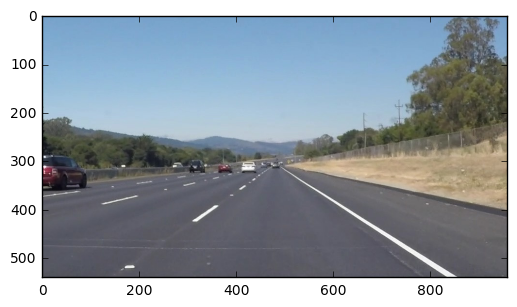

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_noise(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img):
    """
    Applies an image mask.
    """
    hei, wid = img.shape
    #defining a blank mask to start with
    mask = np.zeros_like(img)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        

    # creating outer mask: 
    vertices = np.array([[0.45 * wid, 0.6 * hei], 
                         [0.55 * wid, 0.6 * hei],
                         [       wid,        hei],
                         [ 0.1 * wid,        hei]], np.int32)
    cv2.fillConvexPoly(mask, vertices, ignore_mask_color)

    # creating inner mask:
    vertices = np.array([[0.5 * wid, 0.6 * hei],
                         [0.75 * wid,      hei],
                         [0.25 * wid,      hei]], np.int32)
    cv2.fillConvexPoly(mask, vertices, 0)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    """
    Draws `lines` with `color` and `thickness`.
    
    Lines are drawn on the image inplace (mutates the image).
    """
    if lines is None:
        return
    for line in lines:
        for x1,y1,x2,y2 in line:
            if abs(y1 - y2) < 30: #ignore nearly-horizontal lines
                continue
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def draw_lines2(img, lines, color=[255, 0, 0], thickness=2):
    """
    Draws `lines` with `color` and `thickness`.
    Lines are enlarged to reach the bottom of the image.
    
    Lines are drawn on the image inplace (mutates the image).
    """
    if lines is None:
        return
    for line in lines:
        for x1,y1,x2,y2 in line:
            if abs(y1 - y2) < 30: 
            #ignore nearly-horizontal and nearly-vertical lines
                continue
            if max(y1, y2) > img.shape[1] * 0.9:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                continue
            
            if y1 > y2:
                xb, yb = x1, y1
                xt, yt = x2, y2
            else:
                xb, yb = x2, y2
                xt, yt = x1, y1
            dy = yb - yt
            dx = xb - xt
            dy_bottom = img.shape[1] - yb
            dx_bottom = dx * dy_bottom / dy
            x_bottom = xb + dx_bottom
            if x_bottom < 0:
                x_bottom = 0
            elif x_bottom > img.shape[0]:
                x_bottom = img.shape[0]
            else:
                x_bottom = int(x_bottom)
            y_bottom = int(img.shape[1])

            cv2.line(img, (xt, yt), (x_bottom, y_bottom), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def find_lane_boundaries(img):
    gray = grayscale(img)
    blur = gaussian_noise(gray, 7)
    edges = canny(blur, 50, 150)
    masked = region_of_interest(edges)
    black = np.zeros_like(masked)
    lines_s = hough_lines(masked, 0.1, np.pi/360, 10, 60, 30)
    lines_m = hough_lines(masked, 0.1, np.pi/360, 10, 120, 80)
    lines_l = hough_lines(masked, 0.1, np.pi/360, 20, 180, 100)
#    lines = np.dstack((lines_l, lines_m, lines_s))
    lines_all = lines_s + lines_m + lines_l
    lines = np.dstack((lines_all, black, black))
    overlay = weighted_img(lines.astype("uint8"), img)
    return overlay

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

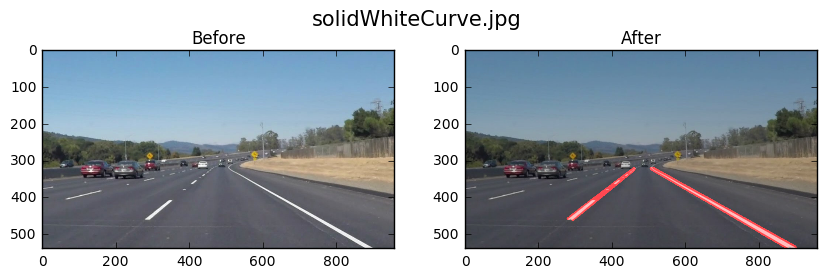

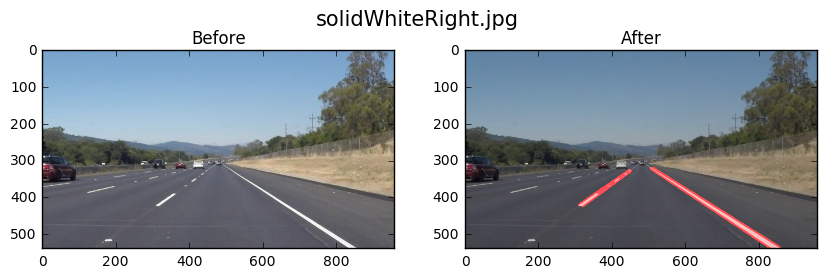

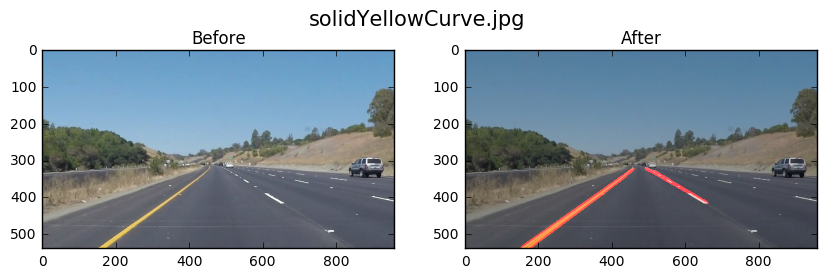

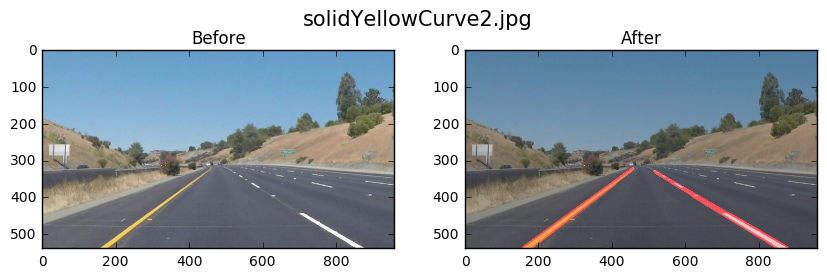

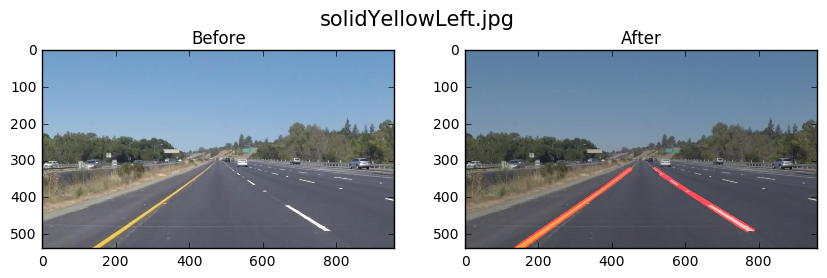

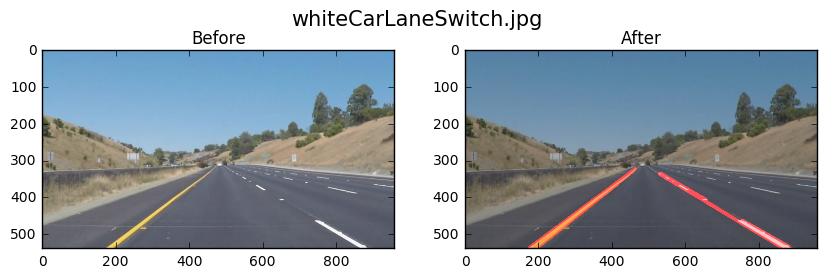

In [4]:
import os
dirname = "test_images/"
imgs = os.listdir(dirname)

for imgname in imgs:
    img = mpimg.imread(dirname+imgname)
    processed_img = find_lane_boundaries(img)
    # print('This image is: ', type(image), 'with dimensions:', image.shape)
    fig = plt.figure(figsize=(10,3))
    fig.suptitle(imgname, fontsize=15)
    ax = plt.subplot(121)
    ax.set_title("Before")
    plt.imshow(img)
    ax = plt.subplot(122)
    ax.set_title("After")
    plt.imshow(processed_img, cmap='gray')


run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [6]:
def process_image(image):
    #implemented above
    return find_lane_boundaries(image)

Let's try the one with the solid white lane on the right first ...

In [7]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:15<00:00, 13.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 11 s, sys: 5.67 s, total: 16.6 s
Wall time: 16.3 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P0_example1.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [9]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:48<00:00, 14.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 34 s, sys: 17.5 s, total: 51.4 s
Wall time: 49.4 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


#### Answer

This seems to work decently even for the challenge: there are very few frames with only one or no lanes found. However, in the two required videos the dashed line detection flickers too much to my liking, while in the challenge itself there are more false positives than I'm comfortable with. I cannot say I'm entirely happy with this result.

I changed a bit some functions to get rid of noisy predictions: adding a triangular mask to the center of the road got rid of a lot of unwanted edges, though I think it might badly impact performance on turns. Then again, I don't think this pipeline is great for turns anyways… Perhaps it'd be best to decompose each lane mark into points and then regress a function that fits through them, but that could be too costly to run in real time.

The fine tuning of the hyperparameters in the Hough algorithm was absolutely trial and error to me. Tuning parameters by hand based on just a couple images seems too hit-and-miss and prone to overfitting—perhaps an optimisation function is in order. Can't say I enjoyed the hand-tuning process. In the end, I used three separate sets of parameters to capture long, medium and short segments, and combine them.

I also attempted the suggested solution of increasing the length of the lines when they're drawn, but the results were very poor (perhaps I misinterpreted it, or my implementation is to blame). I thought of ordering the line segments and connecting one to the other, but I didn't see any outputs where this could help and decided against it. I also attempted closing (i.e. dilatiing and eroding) both the edges image and the lines image, to no avail, so I deleted this function.

I'd _especially_ welcome suggestions on:
- how to use an optimisation function to tune `hough_lines`;
- how to obtain a better intuition of `hough_lines` parameters and their effect on the image;
- how to efficiently implement permanence of boundaries found (if an edge slowly decayed over the next 2 frames instead of being instantaneous, that'd help with frames where no boundaries are found);
- better implementations of `draw_line2` (i.e. the line-enlarging bit);
- thoughts on how to decompose the lines into points and fit a function through them;
- other visual manipulation techniques to try instead of closing;
- anything I could've used to capture the [cat's eyes](https://en.wikipedia.org/wiki/Cat%27s_eye_(road)) that could help close the dashed lines.
- better submissions than my own to check out/speak to the authors.

But obviously I welcome any feedback, suggestions, external reading material and explanations on _anything_ that could improve the performance of my algorithm or my understanding of whatever might seem relevant!

## Submission

If you're satisfied with your video outputs it's time to submit!


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [11]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:26<00:00,  9.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 18.5 s, sys: 9.1 s, total: 27.6 s
Wall time: 27.7 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

^ That looks like it would be a scary ride!